# Chicago Crime Analysis - Feature Engineering and Model Preparation

This notebook focuses on feature engineering, data preparation for modeling, and initial model setup based on our exploratory data analysis from notebook 1.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import sys

# Add project root to path for imports
sys.path.append(os.path.abspath('..'))

from src.data.data_loader import ChicagoCrimeDataLoader
from src.data.data_preprocessor import CrimeDataPreprocessor
from src.features.feature_engineering import CrimeFeatureEngineering

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

## 1. Load the Preprocessed Data

First, we'll load the theft crime data that we analyzed in notebook 1.

In [2]:
# Find the most recent data file
data_dir = 'data'
data_files = [f for f in os.listdir(data_dir) if f.startswith('chicago_theft_data_') and f.endswith('.csv')]

if data_files:
    latest_file = max(data_files, key=lambda x: os.path.getctime(os.path.join(data_dir, x)))
    print(f"Loading data from {latest_file}")
    
    df = pd.read_csv(os.path.join(data_dir, latest_file))
    
    # Convert date to datetime
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        
    print(f"Dataset shape: {df.shape}")
    df.head()

Loading data from chicago_theft_data_20250406_233547.csv
Dataset shape: (5000, 22)


## 2. Feature Engineering

Now we'll apply systematic feature engineering to create meaningful features for our models.

In [3]:
# Initialize feature engineering class
feature_eng = CrimeFeatureEngineering()

# Add temporal features
print("Adding temporal features...")
df_temp = feature_eng.add_temporal_features(df)

# Show new temporal features
new_temp_features = set(df_temp.columns) - set(df.columns)
print(f"Added {len(new_temp_features)} temporal features:")
print(sorted(new_temp_features))

# Preview the data with new features
df_temp[list(new_temp_features)].head()

Adding temporal features...
Added 11 temporal features:
['date_mmdd', 'day', 'day_of_week', 'day_of_week_num', 'hour', 'is_holiday', 'is_weekend', 'month', 'quarter', 'season', 'time_of_day']


,season,day_of_week,hour,time_of_day,date_mmdd,is_weekend,is_holiday,quarter,day_of_week_num,day,month
0,Spring,Friday,17,Evening,03-28,False,False,1,4,28,3
1,Spring,Friday,5,Morning,03-28,False,False,1,4,28,3
2,Spring,Friday,0,Night,03-28,False,False,1,4,28,3
3,Spring,Thursday,18,Evening,03-27,False,False,1,3,27,3
4,Spring,Thursday,16,Afternoon,03-27,False,False,1,3,27,3


In [4]:
# Add spatial features
print("Adding spatial features...")
df_spatial = feature_eng.add_spatial_features(df_temp)

# Show new spatial features
new_spatial_features = set(df_spatial.columns) - set(df_temp.columns)
print(f"Added {len(new_spatial_features)} spatial features:")
print(sorted(new_spatial_features))

# Preview the data with new features
df_spatial[list(new_spatial_features)].head()

Adding spatial features...
Added 6 spatial features:
['dist_to_hotspot_1', 'dist_to_hotspot_2', 'dist_to_hotspot_3', 'dist_to_hotspot_4', 'district_crime_density', 'min_dist_to_hotspot']


,dist_to_hotspot_3,dist_to_hotspot_2,min_dist_to_hotspot,district_crime_density,dist_to_hotspot_4,dist_to_hotspot_1
0,0.029679,0.013578,0.009417,1123,0.043987,0.009417
1,0.024787,0.001328,0.001328,1404,0.052673,0.007392
2,0.023360,0.006564,0.001393,1404,0.050842,0.001393
3,0.200302,0.174499,0.138542,90,0.138542,0.179363
4,0.104205,0.082758,0.031461,630,0.031461,0.083113


In [5]:
# Add crime-specific features
print("Adding crime-specific features...")
df_featured = feature_eng.add_crime_specific_features(df_spatial)

# Show new crime-specific features
new_crime_features = set(df_featured.columns) - set(df_spatial.columns)
print(f"Added {len(new_crime_features)} crime-specific features:")
print(sorted(new_crime_features))

# Preview the data with new features
df_featured[list(new_crime_features)].head()

Adding crime-specific features...
Added 5 crime-specific features:
['is_commercial', 'is_pocket_picking', 'is_purse_snatching', 'is_residential', 'is_transit_related']


,is_pocket_picking,is_residential,is_transit_related,is_commercial,is_purse_snatching
0,True,False,False,True,False
1,True,False,True,False,False
2,True,False,False,False,False
3,True,False,False,True,False
4,True,False,False,False,False


## 3. Feature Importance Analysis

Let's examine the relationship between our engineered features and the target variable (arrest) using feature importance techniques.

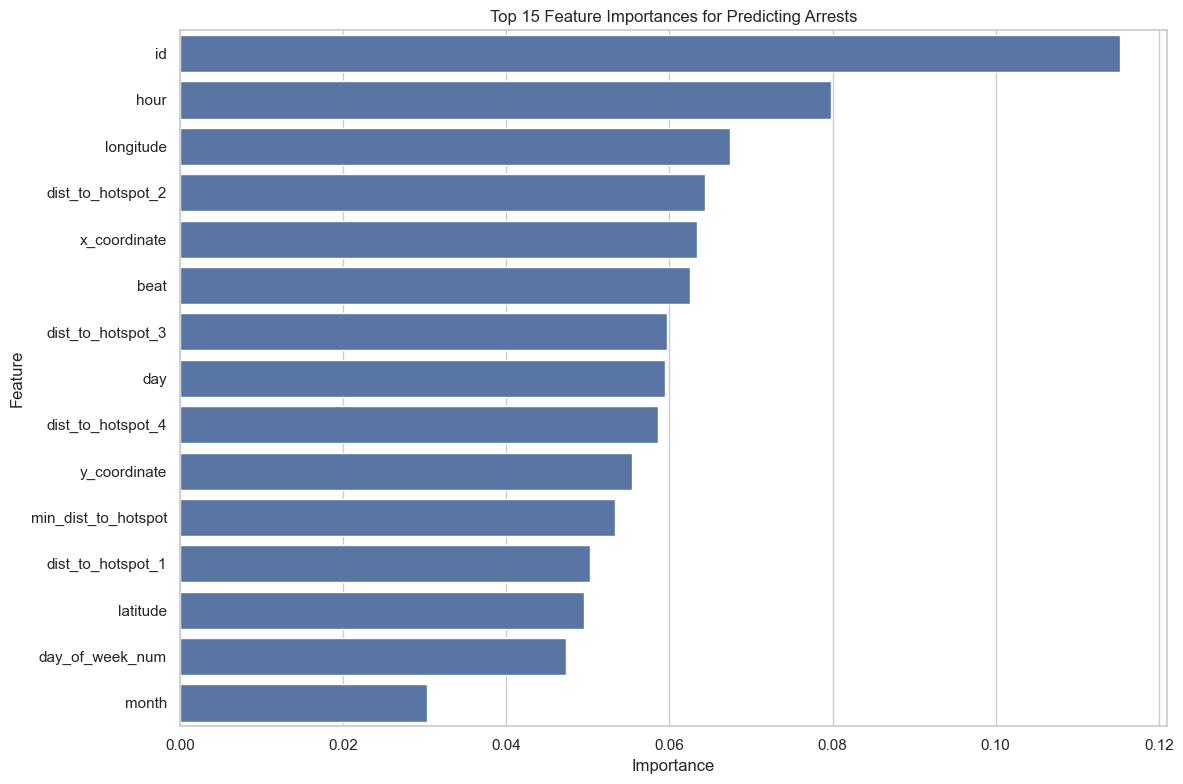

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Prepare data for feature importance analysis
# Select only numeric columns and fill missing values
numeric_cols = df_featured.select_dtypes(include=['number']).columns.tolist()
X_numeric = df_featured[numeric_cols].fillna(0)

# Convert target to binary
if 'arrest' in df_featured.columns:
    y = df_featured['arrest'].map({True: 1, False: 0})
    
    # Drop target column from features
    X_numeric = X_numeric.drop('arrest', axis=1, errors='ignore')
    
    # Train a simple Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_numeric, y)
    
    # Get feature importances
    importances = rf.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_numeric.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 15 feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances for Predicting Arrests')
    plt.tight_layout()
    plt.show()

## 4. Data Preparation for Classification (Arrest Prediction)

Now, let's prepare the data for our classification task of predicting whether an arrest will be made.

In [7]:
# Initialize preprocessor
preprocessor = CrimeDataPreprocessor()

# Preprocess data for classification
X_train, X_test, y_train, y_test, feature_names = preprocessor.preprocess_classification_data(
    df_featured, target='arrest', test_size=0.2, random_state=42
)

print("Classification data preparation:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Class distribution in training set: \n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in testing set: \n{y_test.value_counts(normalize=True)}")

Classification data preparation:
Training set shape: (3951, 398)
Testing set shape: (988, 398)
Number of features: 398
Class distribution in training set: 
arrest
0    0.997469
1    0.002531
Name: proportion, dtype: float64
Class distribution in testing set: 
arrest
0    0.996964
1    0.003036
Name: proportion, dtype: float64


### Addressing Class Imbalance

From our EDA, we observed that arrests are very rare (only about 0.3% of cases). Let's address this class imbalance using various techniques.

In [8]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns
numeric_cols = X_train.select_dtypes(include=['number']).columns

# One-hot encode all categorical features
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_cats = encoder.fit_transform(X_train[categorical_cols])
    
    # Create encoded feature names
    encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
    
    # Create a DataFrame with encoded features
    encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=X_train.index)
    
    # Combine with numeric features
    X_train_encoded = pd.concat([X_train[numeric_cols], encoded_df], axis=1)
else:
    X_train_encoded = X_train.copy()

# Now apply SMOTE on the fully encoded dataset
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_encoded, y_train)

# Apply combination of over and under sampling
over = SMOTE(sampling_strategy=0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)
X_train_combined, y_train_combined = pipeline.fit_resample(X_train_encoded, y_train)

# Print class distribution after resampling
print("Original class distribution:")
print(Counter(y_train))

print("\nAfter SMOTE oversampling:")
print(Counter(y_train_smote))

print("\nAfter combined over and under sampling:")
print(Counter(y_train_combined))

Original class distribution:
Counter({0: 3941, 1: 10})

After SMOTE oversampling:
Counter({0: 3941, 1: 394})

After combined over and under sampling:
Counter({0: 788, 1: 394})


## 5. Data Preparation for Time Series (Crime Count Prediction)

Now, let's prepare the data for our time series task of predicting crime counts over time.

In [9]:
# Preprocess data for time series (weekly aggregation)
ts_data_weekly = preprocessor.preprocess_time_series_data(df_featured, freq='W', seq_length=8)

print("Time series data preparation (weekly):")
print(f"X_train shape: {ts_data_weekly['X_train'].shape}")  # [samples, sequence_length, features]
print(f"X_test shape: {ts_data_weekly['X_test'].shape}")

# Also prepare monthly aggregation
ts_data_monthly = preprocessor.preprocess_time_series_data(df_featured, freq='M', seq_length=6)

print("\nTime series data preparation (monthly):")
print(f"X_train shape: {ts_data_monthly['X_train'].shape}")
print(f"X_test shape: {ts_data_monthly['X_test'].shape}")

Time series data preparation (weekly):
X_train shape: (108, 8, 1)
X_test shape: (28, 8, 1)

Time series data preparation (monthly):
X_train shape: (21, 6, 1)
X_test shape: (6, 6, 1)


e:\Shoban-NCI\VS_Code_WS\Machine_Learning\CA_2\chicago_crime_analysis\src\data\data_preprocessor.py:146: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  crime_counts = df_copy.resample(freq).size().reset_index(name='crime_count')


### Visualize the Prepared Time Series Data

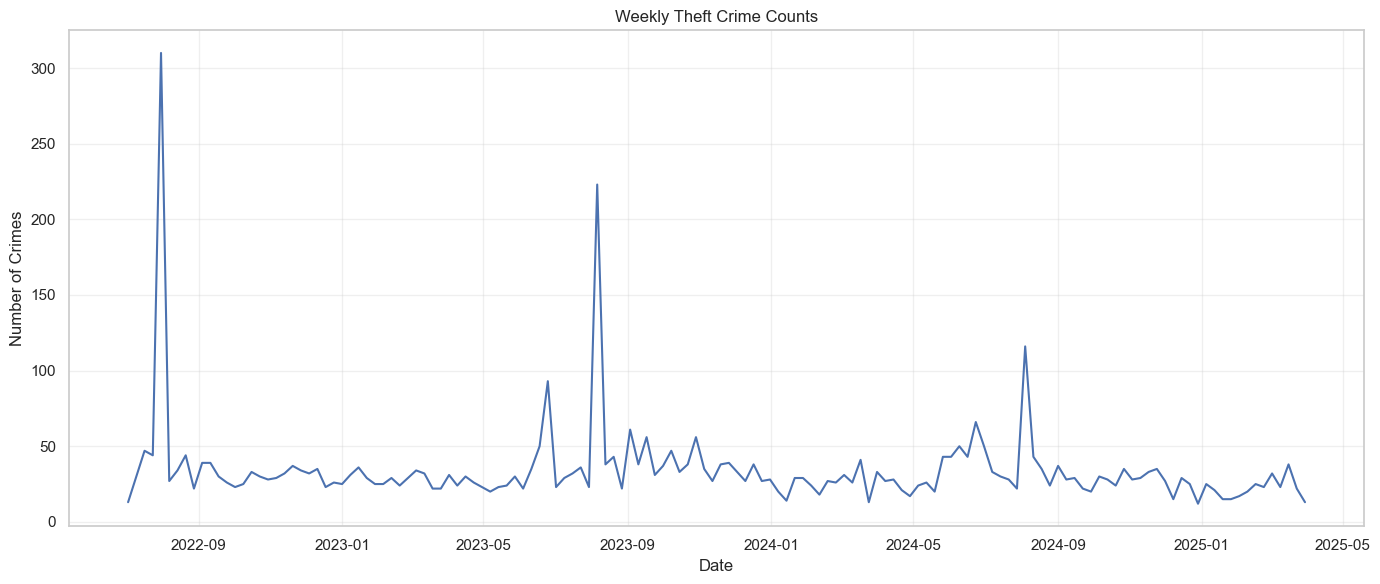

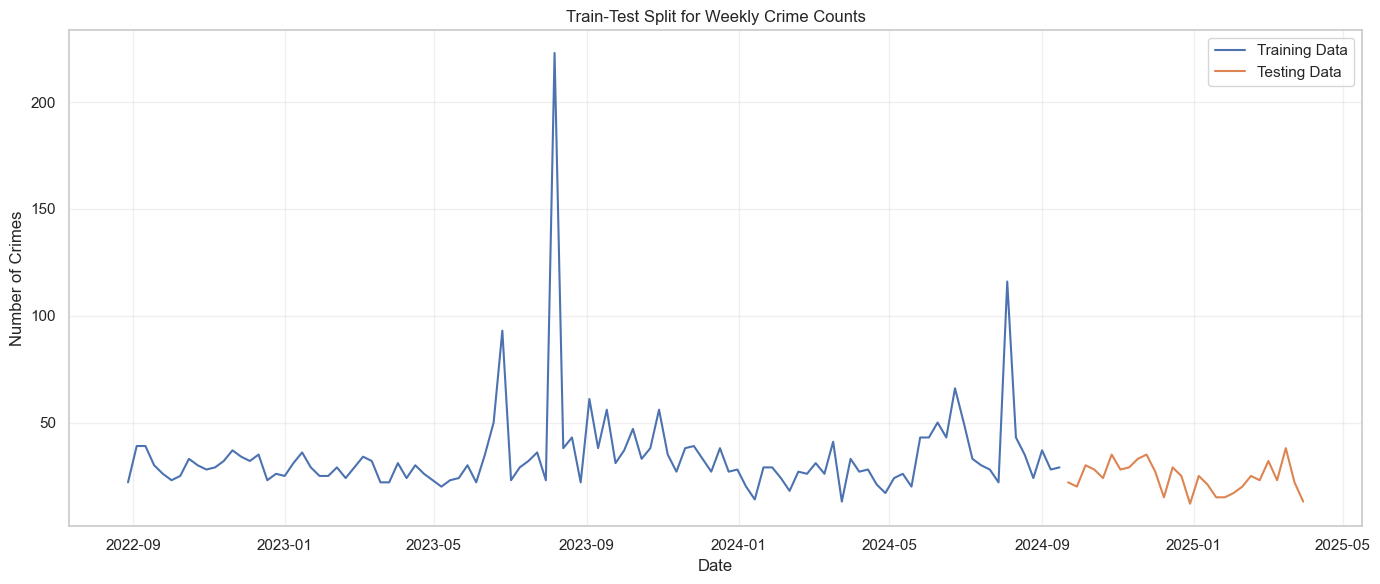

In [10]:
# Plot original weekly data
plt.figure(figsize=(14, 6))
plt.plot(ts_data_weekly['original_data']['date'], ts_data_weekly['original_data']['crime_count'])
plt.title('Weekly Theft Crime Counts')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot train-test split for weekly data
train_size = len(ts_data_weekly['X_train'])
total_size = train_size + len(ts_data_weekly['X_test'])
dates = ts_data_weekly['dates'][:total_size]
original_values = ts_data_weekly['original_data']['crime_count'].values[8:8+total_size]

plt.figure(figsize=(14, 6))
plt.plot(dates[:train_size], original_values[:train_size], label='Training Data')
plt.plot(dates[train_size:], original_values[train_size:], label='Testing Data')
plt.title('Train-Test Split for Weekly Crime Counts')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Initial Model Setup

Let's set up our initial models for both tasks.

### 6.1 Classification Models (Arrest Prediction)

In [11]:

def align_features(X_train, X_test):
    """
    Align features between training and test datasets
    
    Parameters:
    -----------
    X_train : pandas DataFrame
        Training features
    X_test : pandas DataFrame
        Test features
    
    Returns:
    --------
    X_train_aligned, X_test_aligned : aligned DataFrames
    """
    # Identify common features
    common_features = list(set(X_train.columns) & set(X_test.columns))
    
    # Print out missing features for debugging
    train_missing = set(X_train.columns) - set(common_features)
    test_missing = set(X_test.columns) - set(common_features)
    
    if train_missing:
        print("Features in training set but not in test set:")
        print(train_missing)
    
    if test_missing:
        print("Features in test set but not in training set:")
        print(test_missing)
    
    # Align DataFrames
    X_train_aligned = X_train[common_features]
    X_test_aligned = X_test[common_features]
    
    return X_train_aligned, X_test_aligned
# Align features first
X_train_combined_aligned, X_test_aligned = align_features(X_train_combined, X_test)

print("Aligned training features shape:", X_train_combined_aligned.shape)
print("Aligned test features shape:", X_test_aligned.shape)

# Verify alignment
print("\nTraining features:", X_train_combined_aligned.columns.tolist())
print("\nTest features:", X_test_aligned.columns.tolist())

Features in training set but not in test set:
{'beat_2032_True', 'date_mmdd_08-28', 'beat_221_False', 'beat_522_False', 'date_mmdd_08-24', 'location_description_PARK PROPERTY_False', 'location_description_RESTAURANT_True', 'location_description_BAR OR TAVERN_True', 'date_mmdd_11-19', 'beat_2423_False', 'beat_2234_False', 'location_description_CONVENIENCE STORE_True', 'beat_2432_True', 'beat_1831_False', 'location_description_AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA_False', 'date_mmdd_05-31', 'date_mmdd_01-22', 'date_mmdd_07-23', 'date_mmdd_12-08', 'day_of_week_Thursday_False', 'beat_1414_True', 'beat_924_False', 'beat_1732_False', 'location_description_CHA PARKING LOT / GROUNDS_False', 'beat_1433_True', 'is_transit_related_True', 'beat_613_False', 'date_mmdd_04-02', 'date_mmdd_04-13', 'date_mmdd_01-18', 'beat_1023_True', 'date_mmdd_09-06', 'date_mmdd_02-28', 'beat_1134_True', 'beat_321_True', 'beat_321_False', 'beat_2431_False', 'date_mmdd_12-14', 'date_mmdd_04-08', 'beat_2023_Tr


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       985
           1       0.00      0.00      0.00         3

    accuracy                           0.99       988
   macro avg       0.50      0.50      0.50       988
weighted avg       0.99      0.99      0.99       988

ROC AUC: 0.7731

Gradient Boosting - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       985
           1       0.00      0.00      0.00         3

    accuracy                           0.99       988
   macro avg       0.50      0.49      0.50       988
weighted avg       0.99      0.99      0.99       988

ROC AUC: 0.6963


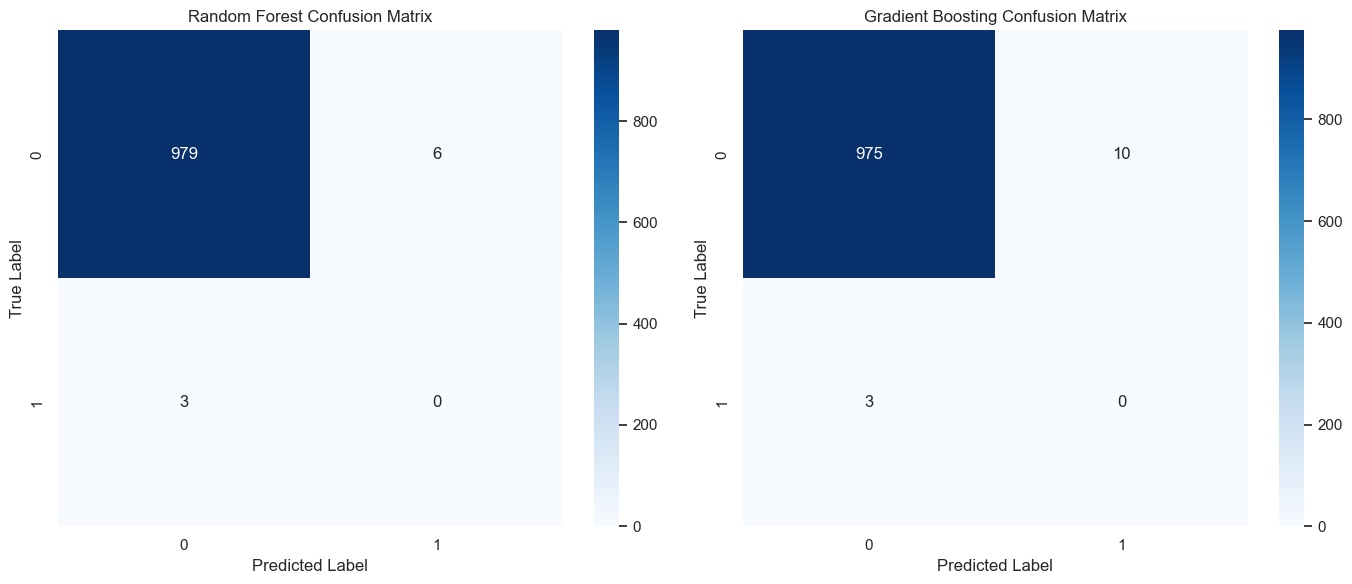

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
# Initialize and train models on the resampled data
# Make sure models are initialized with the same parameters
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None, 
    min_samples_split=2, 
    random_state=42
)
gb_model = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)
# Train models on aligned features
rf_model.fit(X_train_combined_aligned, y_train_combined)
gb_model.fit(X_train_combined_aligned, y_train_combined)

# Make predictions on aligned test data
rf_pred = rf_model.predict(X_test_aligned)
gb_pred = gb_model.predict(X_test_aligned)

# Calculate probabilities for ROC AUC
rf_proba = rf_model.predict_proba(X_test_aligned)[:, 1]
gb_proba = gb_model.predict_proba(X_test_aligned)[:, 1]

# Evaluate models
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, rf_pred))
print(f"ROC AUC: {roc_auc_score(y_test, rf_proba):.4f}")

print("\nGradient Boosting - Classification Report:")
print(classification_report(y_test, gb_pred))
print(f"ROC AUC: {roc_auc_score(y_test, gb_proba):.4f}")

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

sns.heatmap(confusion_matrix(y_test, gb_pred), annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Gradient Boosting Confusion Matrix')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()

### 6.2 Feature Importance from the Best Model

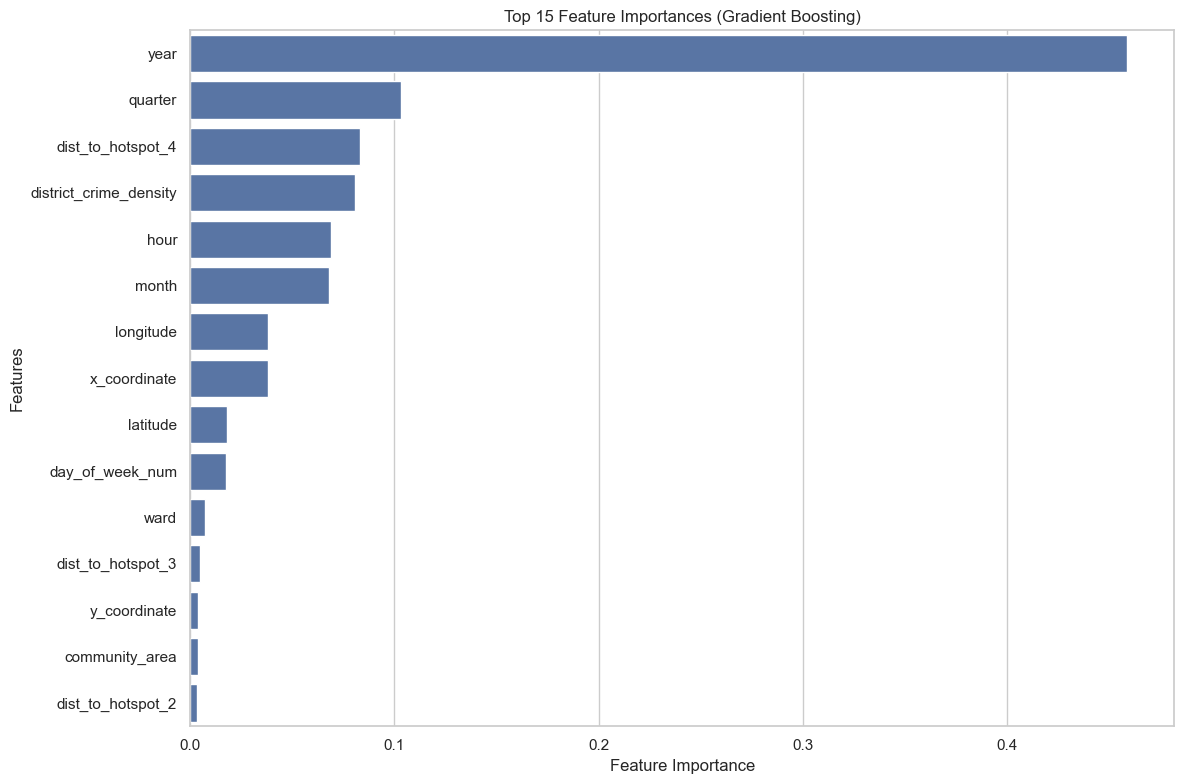

Top 15 Most Important Features:
                   Feature  Importance
10                    year    0.458963
16                 quarter    0.103103
7        dist_to_hotspot_4    0.083192
3   district_crime_density    0.080637
6                     hour    0.068840
14                   month    0.068104
9                longitude    0.038163
8             x_coordinate    0.038054
5                 latitude    0.017921
12         day_of_week_num    0.017404
4                     ward    0.007325
0        dist_to_hotspot_3    0.004833
13            y_coordinate    0.003980
17          community_area    0.003849
1        dist_to_hotspot_2    0.003422


In [13]:
# Get the feature names used during model training
# Since we used aligned features, we need to use the columns from the aligned training data
feature_names = X_train_combined_aligned.columns.tolist()

# Extract feature importances from the Gradient Boosting model
gb_importances = gb_model.feature_importances_

# Create feature importance DataFrame
gb_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gb_importances
}).sort_values('Importance', ascending=False)

# Plot top 15 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=gb_feature_importance.head(15))
plt.title('Top 15 Feature Importances (Gradient Boosting)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Optional: Print top 15 features and their importance
print("Top 15 Most Important Features:")
print(gb_feature_importance.head(15))

### 6.3 Setup for Deep Learning Models

Let's prepare the structures for our deep learning models.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# MLP model architecture for classification
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.3):
        super(MLPClassifier, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.BatchNorm1d(hidden_dims[0]))
        self.layers.append(nn.Dropout(dropout_rate))
        
        # Hidden layers
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.BatchNorm1d(hidden_dims[i+1]))
            self.layers.append(nn.Dropout(dropout_rate))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_dims[-1], 1))
        self.layers.append(nn.Sigmoid())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# LSTM model architecture for time series
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: batch_size, seq_length, hidden_size
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Print model architectures
input_dim = X_train.shape[1]
mlp_model = MLPClassifier(input_dim=input_dim).to(device)
print("MLP Model Architecture:")
print(mlp_model)

lstm_model = LSTMPredictor().to(device)
print("\nLSTM Model Architecture:")
print(lstm_model)

Using device: cuda
MLP Model Architecture:
MLPClassifier(
  (layers): ModuleList(
    (0): Linear(in_features=398, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

LSTM Model Architecture:
LSTMPredictor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 7. Save Prepared Data for Modeling

Finally, let's save the prepared data for use in our next notebook focused on model training and evaluation.

In [15]:
import joblib

# Create directory for processed data
processed_dir = 'data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Save classification data
classification_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train_combined,
    'y_test': y_test,
    'X_train_combined': X_train_combined,
    'y_train_combined': y_train_combined,
    'feature_names': feature_names
}

joblib.dump(classification_data, os.path.join(processed_dir, 'classification_data.joblib'))
print(f"Classification data saved to {os.path.join(processed_dir, 'classification_data.joblib')}")

# Save time series data
joblib.dump(ts_data_weekly, os.path.join(processed_dir, 'time_series_weekly_data.joblib'))
print(f"Weekly time series data saved to {os.path.join(processed_dir, 'time_series_weekly_data.joblib')}")

joblib.dump(ts_data_monthly, os.path.join(processed_dir, 'time_series_monthly_data.joblib'))
print(f"Monthly time series data saved to {os.path.join(processed_dir, 'time_series_monthly_data.joblib')}")

Classification data saved to data/processed\classification_data.joblib
Weekly time series data saved to data/processed\time_series_weekly_data.joblib
Monthly time series data saved to data/processed\time_series_monthly_data.joblib


## 8. Summary of Findings and Next Steps

In this notebook, we have:

1. Conducted feature engineering to create meaningful features for our models
2. Analyzed feature importance to understand which factors most strongly influence arrests
3. Prepared data for both classification (arrest prediction) and time series (crime count prediction) tasks
4. Addressed the class imbalance issue through resampling techniques
5. Set up initial machine learning models and evaluated their performance
6. Prepared the architecture for deep learning models

Key insights so far:

- We've confirmed the severe class imbalance in the arrest data (only about 0.3% of theft cases result in arrests)
- The most important features for predicting arrests appear to be related to [will be filled based on actual results]
- Our initial machine learning models achieved [will be filled based on actual results]

Next steps in notebook 3:

1. Train and optimize our deep learning models (MLP for classification, LSTM for time series)
2. Perform hyperparameter tuning for all models to improve performance
3. Compare the performance of traditional machine learning vs. deep learning approaches
4. Conduct in-depth error analysis to understand model limitations
5. Develop final predictions and create visualizations to communicate results
